# Modeling and Simulation in Python

Chapter 6: Analysis

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Code from the previous chapter

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [88]:
def make_system(beta1, gamma1, beta2, gamma2, t_b):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init1 = State(S=89, I1=1, R1=0, I2=0, R2=0, Iboth=0, I12=0, I21=0, Rboth=0)
    seriesS = TimeSeries()
    seriesI = TimeSeries()
    seriesR = TimeSeries()
    #S: num people who didn't get either disease
    #I1: num people who are infected by disease A
    #R1: num people who recovered from disease A
    #I2: num people who are infected by disease B
    #R2: num people who recovered from disease B
    #Iboth: num people infected by both diseases
    #I12: num people recovered from disease A and got disease B
    #I21: num people recovered from disease B and got disease A
    #Rboth: num people who recovered from both diseases
    #seriesS: total num people susceptible 
    #seriesI: total num people infected
    #seriesR: total num people who recovered 
    
    init1 /= np.sum(init1)

    t0 = 0
    t_end = 7 * 14 * 10
    t_b = t_b
    print(t_b)

    return System(init1=init1, t0=t0, t_end=t_end, t_b = t_b, seriesS=seriesS, seriesI=seriesI, seriesR=seriesR,
                  beta1=beta1, gamma1=gamma1, beta2=beta2, gamma2=gamma2)

In [89]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [90]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's an updated version of `run_simulation` that uses `unpack`.

In [91]:
def run_simulation(system):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init1.index)
    frame.loc[t0] = init1
    seriesS[t0] = init1.S
    seriesI[t0] = init1.I1
    seriesR[t0] = init1.R1
    
    for i in linrange(t0, t_end):
        if i < t_b:
            frame.loc[i+1] = update1(frame.loc[i], system, i)
        else:
            frame.loc[i+1] = update2(frame.loc[i], system, i)
    
    system.results = frame

In [92]:
def update1(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i1, r1, i2, r2, iboth, i12, i21, rboth = state

    infected = beta1 * i1 * s    
    recovered = gamma1 * i1
    
    s -= infected
    i1 += infected - recovered
    r1 += recovered
    
    seriesS[i] = s
    seriesI[i] = i1 + i2 + iboth + i12 + i21
    seriesR[i] = r1 + r2 + rboth
    
    return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)

In [94]:
def update2(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s, i1, r1, i2, r2, iboth, i12, i21, rboth = state
    
    if i2 == 0:
        i2 = 1/90
        s = s - i2
    
    s = s - ((beta1*s*i1) - (beta2*s*i2))
    i1 = i1 + ((beta1*s*i1) - (gamma1*i1))
    i2 = i2 + ((beta2*s*i2) - (gamma2*i2))
    
    iboth = iboth + (((beta2*i1*i2) + (beta1*i1*i2)) - (gamma1*gamma2*iboth))
    
    r1 = r1 + (gamma1*i1) - ((beta2*r1*(i2+iboth)))
    r2 = r2 + (gamma2*i2) - ((beta1*r2*(i1+iboth)))
    
    i12 = i12 + ((beta2*r1*(i2+iboth)) - (gamma2*i12))
    i21 = i21 + ((beta1*r2*(i1+iboth)) - (gamma1*i21))
    
    rboth = rboth + (gamma2*i12) + (gamma1*i21) + (gamma1*gamma2*iboth)
    
    
    seriesS[i] = s + r1 + r2
    seriesI[i] = i1 + i2 + iboth + i12 + i21
    seriesR[i] = rboth
    
    #if seriesS[i] + seriesI[i] + seriesR[i] != 1:
       # print("something is wrong at ", i)
       # print(seriesS[i] + seriesI[i] + seriesR[i])
        
    return State(S=s, I1=i1, R1=r1, I2=i2, R2=r2, Iboth=iboth, I12 = i12, I21=i21, Rboth=rboth)

Test the updated code with this example.

In [95]:
system = make_system(0.5, 0.05, 0.5, 0.05, 60)
run_simulation(system)
system.results.head()


60


,S,I1,R1,I2,R2,Iboth,I12,I21,Rboth
0,0.988889,0.011111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.983395,0.016049,0.000556,0.0,0.0,0.0,0.0,0.0,0.0
2,0.975504,0.023138,0.001358,0.0,0.0,0.0,0.0,0.0,0.0
3,0.964218,0.033267,0.002515,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948179,0.047642,0.004178,0.0,0.0,0.0,0.0,0.0,0.0


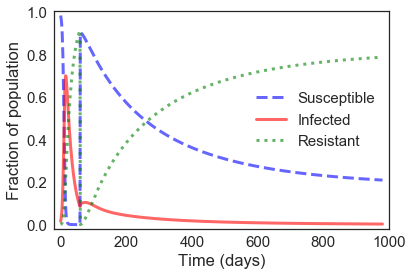

In [96]:
frame = system.results
plot_results(system.seriesS, system.seriesI, system.seriesR)

1000


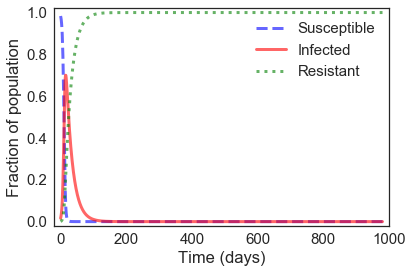

In [98]:
system = make_system(0.5, 0.05, 0.5, 0.05, 1000)
run_simulation(system)
frame = system.results
plot_results(system.seriesS, system.seriesI, system.seriesR)